In [1]:
import torch
from pkg.datasets import IDSDataset
from pkg.lit_sad import LitIDSVAE_SAD

In [2]:
from torchvision import transforms, utils
from tqdm import tqdm
import pickle
import pandas as pd
# Маппинги айпи адресов
with open('Data/sip_map.pkl', 'rb') as f:
    sip_map = pickle.load(f)
with open('Data/dip_map.pkl', 'rb') as f:
    dip_map = pickle.load(f)

In [3]:
PATH = 'Models/vae-sad-epoch=6-step=20922.ckpt'
model = LitIDSVAE_SAD.load_from_checkpoint(PATH, sip_map=sip_map, dip_map=dip_map, use_category=False)

In [4]:
from torchvision import transforms, utils
from tqdm import tqdm, tqdm_notebook
import pickle
import pandas as pd

ds_test = IDSDataset('Data/all_test.csv', sip_map, dip_map, only_anomaly=False, transform=True,
                    stat=pd.read_csv('Data/all_stat.csv').rename({0:'count', 1:'mean', 2:'std', 3:'min', 4:'25%', 5:'50%', 6:'75%', 7:'max'}))
                    
test_dataloader = torch.utils.data.DataLoader(ds_test, batch_size=3**4,
                        shuffle=False, num_workers=4)

In [6]:
device = torch.device('cpu')
model = model.to(device)

In [7]:
losses = []
labels = []
with torch.no_grad():
    model.eval()
    for row in tqdm(test_dataloader):
        categorical = row[0].to(device)
        continuous =  row[1].to(device).unsqueeze(-2)
        labels.append(row[2])
        x = model.categorical_emb(categorical, continuous) 
        mu_p, logvar_p = model(x)
        dist = 0.5 * torch.sum(model.v_c - logvar_p  - 1 + (mu_p - model.m_c) * \
            (1 / model.v_c.exp()) * (mu_p - model.m_c) + \
              (1 / model.v_c.exp()) * logvar_p.exp(), dim=-1)
        # dist = torch.mean(dist, dim=-1)
        losses.append(dist)

100%|██████████| 2613/2613 [02:24<00:00, 18.08it/s]


In [8]:
new_dict = {'dist': torch.cat(losses).cpu().numpy()}
labels_cat = torch.cat(labels) != 0
# losses_cat = torch.cat(val_losses).cpu()
test_out = pd.DataFrame({ 'is_attack':labels_cat, 'attack_class': torch.cat(labels).numpy(), **new_dict})
test_out.to_csv('test_results_sad.csv')

In [9]:
import numpy as np
new_dict['dist'][np.isnan(new_dict['dist'])] = 0
new_dict['dist'][np.isinf(new_dict['dist'])] = 1e+6

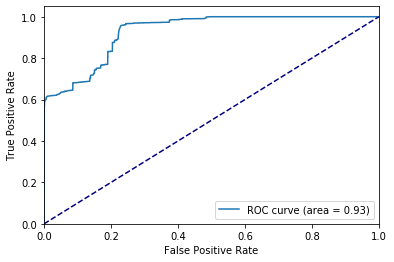

In [10]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(labels_cat.int().numpy(), new_dict['dist'])
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots()
ax.plot(fpr, tpr, 
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc))
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")

In [11]:
thresh_dist = np.sqrt((1 - fpr) ** 2 + tpr ** 2)

In [12]:
np.argmax(thresh_dist)

8037

In [13]:
IDX = 8040
threshold = thresholds[IDX]
test_out['predicted'] = test_out.dist > threshold

In [14]:
from sklearn.metrics import classification_report, f1_score
y_gts = test_out['is_attack']
y_preds = test_out['predicted']
rep = classification_report(y_gts, y_preds, target_names=['No attack', 'Attack'])
print(rep)

              precision    recall  f1-score   support

   No attack       0.98      0.77      0.86    158628
      Attack       0.58      0.96      0.72     53007

    accuracy                           0.82    211635
   macro avg       0.78      0.86      0.79    211635
weighted avg       0.88      0.82      0.83    211635



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=56316f98-13a2-452c-be31-8997c1e2f7a7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>